In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
%matplotlib inline

In [2]:
import tensorflow
print (tensorflow.__version__)

2.4.0


In [3]:
!wget https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/horse2zebra.zip

--2020-12-24 11:59:41--  https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/horse2zebra.zip
Resolving people.eecs.berkeley.edu (people.eecs.berkeley.edu)... 128.32.244.190
Connecting to people.eecs.berkeley.edu (people.eecs.berkeley.edu)|128.32.244.190|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 116867962 (111M) [application/zip]
Saving to: ‘horse2zebra.zip’

horse2zebra.zip     100%[===================>] 111.45M  6.04MB/s    in 17s     

2020-12-24 11:59:58 (6.61 MB/s) - ‘horse2zebra.zip’ saved [116867962/116867962]



In [4]:
!unzip horse2zebra.zip

Archive:  horse2zebra.zip
   creating: horse2zebra/
   creating: horse2zebra/trainA/
  inflating: horse2zebra/trainA/n02381460_6223.jpg  
  inflating: horse2zebra/trainA/n02381460_1567.jpg  
  inflating: horse2zebra/trainA/n02381460_3354.jpg  
  inflating: horse2zebra/trainA/n02381460_299.jpg  
  inflating: horse2zebra/trainA/n02381460_3001.jpg  
  inflating: horse2zebra/trainA/n02381460_4242.jpg  
  inflating: horse2zebra/trainA/n02381460_1666.jpg  
  inflating: horse2zebra/trainA/n02381460_4396.jpg  
  inflating: horse2zebra/trainA/n02381460_4502.jpg  
  inflating: horse2zebra/trainA/n02381460_8527.jpg  
  inflating: horse2zebra/trainA/n02381460_14.jpg  
  inflating: horse2zebra/trainA/n02381460_706.jpg  
  inflating: horse2zebra/trainA/n02381460_4019.jpg  
  inflating: horse2zebra/trainA/n02381460_1478.jpg  
  inflating: horse2zebra/trainA/n02381460_3449.jpg  
  inflating: horse2zebra/trainA/n02381460_5558.jpg  
  inflating: horse2zebra/trainA/n02381460_969.jpg  
  inflating: horse2

In [3]:
!ls horse2zebra

testA  testB  trainA  trainB


In [4]:
import glob
horses_train = glob.glob('horse2zebra/trainA/*.jpg')
zebras_train = glob.glob('horse2zebra/trainB/*.jpg')
horses_test = glob.glob('horse2zebra/testA/*.jpg')
zebras_test = glob.glob('horse2zebra/testB/*.jpg')

In [5]:
len(horses_train), len(zebras_train), len(horses_test), len(zebras_test)

(1067, 1334, 120, 140)

In [6]:
import cv2
for file in horses_train[:10]:
    img = cv2.imread(file)
    print (img.shape)

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


Horses


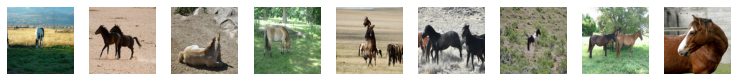

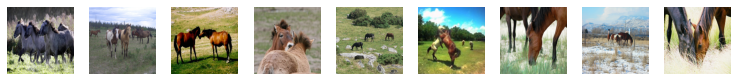

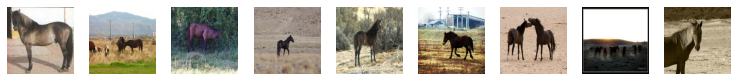

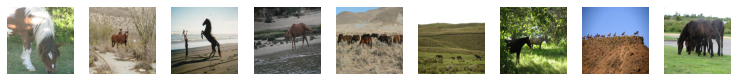

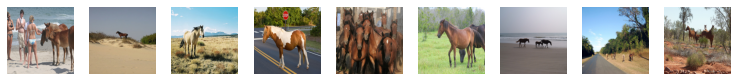

--------------------------------------------------------------------------------
Zebras


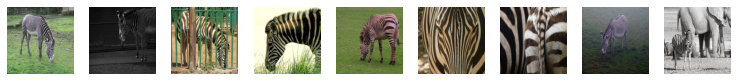

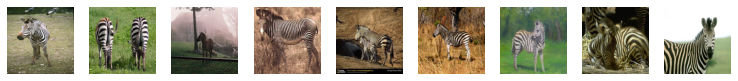

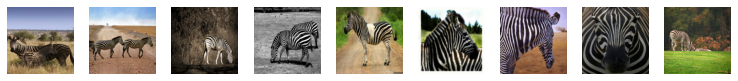

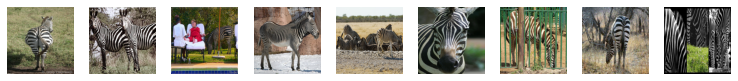

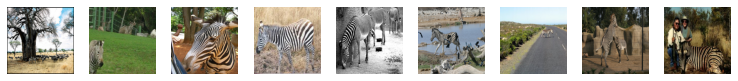

In [7]:
print ("Horses")
for k in range(5):
    plt.figure(figsize=(13, 13))
    for j in range(9):
        file = np.random.choice(horses_train)
        img = cv2.imread(file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(990 + 1 + j)
        plt.imshow(img)
        plt.axis('off')
        #plt.title(trainY[i])
    plt.show()

print ("-"*80)
print ("Zebras")
for k in range(5):
    plt.figure(figsize=(13, 13))
    for j in range(9):
        file = np.random.choice(zebras_train)
        img = cv2.imread(file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(990 + 1 + j)
        plt.imshow(img)
        plt.axis('off')
        #plt.title(trainY[i])
    plt.show()

# Generator Model (U-Net Like)

In [8]:
def encoder_layer(input_layer, filters, bn=True):
    x = tensorflow.keras.layers.Conv2D(filters, kernel_size=(4,4), strides=(2,2), padding='same')(input_layer)
    x = tensorflow.keras.layers.LeakyReLU(alpha=0.2)(x)
    if bn:
        x = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(x)
    return x

def decoder_layer(input_layer, skip_input, filters):
    #x = tensorflow.keras.layers.UpSampling2D(size=2)(input_layer)
    x = tensorflow.keras.layers.Conv2DTranspose(filters, kernel_size=(4,4), strides=(2,2), padding='same')(input_layer)
    x = tensorflow.keras.layers.Activation('relu')(x)
    x = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(x)
    x = tensorflow.keras.layers.Concatenate()([x, skip_input])
    return x

In [9]:
source_image_A = tensorflow.keras.layers.Input(shape=(256, 256, 3))
source_image_B = tensorflow.keras.layers.Input(shape=(256, 256, 3))

def make_generator():
    source_image = tensorflow.keras.layers.Input(shape=(256, 256, 3))

    e1 = encoder_layer(source_image, 32, bn=False)
    e2 = encoder_layer(e1, 64)
    e3 = encoder_layer(e2, 128)
    e4 = encoder_layer(e3, 256)
    e5 = encoder_layer(e4, 256)
    e6 = encoder_layer(e5, 256)
    e7 = encoder_layer(e6, 256)

    bottle_neck = tensorflow.keras.layers.Conv2D(512, (4,4), strides=(2,2), padding='same')(e7)
    b = tensorflow.keras.layers.Activation('relu')(bottle_neck)

    d1 = decoder_layer(b, e7, 256)
    d2 = decoder_layer(d1, e6, 256)
    d3 = decoder_layer(d2, e5, 256)
    d4 = decoder_layer(d3, e4, 256)
    d5 = decoder_layer(d4, e3, 256)
    d6 = decoder_layer(d5, e2, 64)
    d7 = decoder_layer(d6, e1, 32)

    decoded = tensorflow.keras.layers.Conv2DTranspose(3, kernel_size=(4,4), strides=(2,2), padding='same')(d7)
    translated_image = tensorflow.keras.layers.Activation('tanh')(decoded)
    return source_image, translated_image

source_image, translated_image = make_generator()
generator_network_AB = tensorflow.keras.models.Model(inputs=source_image, outputs=translated_image)

source_image, translated_image = make_generator()
generator_network_BA = tensorflow.keras.models.Model(inputs=source_image, outputs=translated_image)

print (generator_network_AB.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 32) 1568        input_3[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 128, 128, 32) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 64)   32832       leaky_re_lu[0][0]                
______________________________________________________________________________________________

# Discriminator Network

In [10]:
def my_conv_layer(input_layer, filters, bn=True):
    x = tensorflow.keras.layers.Conv2D(filters, kernel_size=(4,4), strides=(2,2), padding='same')(input_layer)
    x = tensorflow.keras.layers.LeakyReLU(alpha=0.2)(x)
    if bn:
        x = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(x)
    return x

In [11]:
 def make_discriminator():
    target_image_input = tensorflow.keras.layers.Input(shape=(256, 256, 3))

    x = my_conv_layer(target_image_input, 64, bn=False)
    x = my_conv_layer(x, 128)
    x = my_conv_layer(x, 256)
    x = my_conv_layer(x, 512)
    x = my_conv_layer(x, 512)

    patch_features = tensorflow.keras.layers.Conv2D(1, kernel_size=(4,4), strides=(1,1), padding='same')(x)
    return target_image_input, patch_features


target_image_input, patch_features = make_discriminator()
discriminator_network_A = tensorflow.keras.models.Model(inputs=target_image_input, outputs=patch_features)

target_image_input, patch_features = make_discriminator()
discriminator_network_B = tensorflow.keras.models.Model(inputs=target_image_input, outputs=patch_features)

print (discriminator_network_A.summary())

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 128, 128, 64)      3136      
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 64, 64, 128)       131200    
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 64, 64, 128)       0         
_________________________________________________________________
batch_normalization_26 (Batc (None, 64, 64, 128)       512       
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 32, 32, 256)       5245

In [12]:
adam_optimizer = tensorflow.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
discriminator_network_A.compile(loss='mse', optimizer=adam_optimizer, metrics=['accuracy'])
discriminator_network_B.compile(loss='mse', optimizer=adam_optimizer, metrics=['accuracy'])

# Cycle-GAN

In [13]:
# Domain Transfer
fake_B = generator_network_AB(source_image_A)
fake_A = generator_network_BA(source_image_B)

# Restoring original Domain
get_back_A = generator_network_BA(fake_B)
get_back_B = generator_network_AB(fake_A)

# Get back Identical/Same Image
get_same_A = generator_network_BA(source_image_A)
get_same_B = generator_network_AB(source_image_B)
  
discriminator_network_A.trainable=False
discriminator_network_B.trainable=False

# Tell Real vs Fake, for a given domain
verify_A = discriminator_network_A(fake_A)
verify_B = discriminator_network_B(fake_B)

cycle_gan = tensorflow.keras.models.Model(inputs = [source_image_A, source_image_B], \
                              outputs = [verify_A, verify_B, get_back_A, get_back_B, get_same_A, get_same_B])
cycle_gan.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
model_1 (Functional)            (None, 256, 256, 3)  16893635    input_2[0][0]                    
                                                                 model[0][0]                      
                                                                 input_1[0][0]                    
____________________________________________________________________________________________

# Compiling Models

In [14]:
cycle_gan.compile(loss=['mse', 'mse', 'mae', 'mae', 'mae', 'mae'], loss_weights=[1, 1, 10, 10, 5, 5],\
                                          optimizer=adam_optimizer)

# Define Data Generators

In [15]:
def horses_to_zebras(horses, generator_network):
    generated_samples = generator_network.predict_on_batch(horses)
    return generated_samples

def zebras_to_horses(zebras, generator_network):
    generated_samples = generator_network.predict_on_batch(zebras)
    return generated_samples

def get_horse_samples(batch_size):
    random_files = np.random.choice(horses_train, size=batch_size)
    images = []
    for file in random_files:
        img = cv2.imread(file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images.append((img-127.5)/127.5)
    horse_images = np.array(images)
    return horse_images

def get_zebra_samples(batch_size):
    random_files = np.random.choice(zebras_train, size=batch_size)
    images = []
    for file in random_files:
        img = cv2.imread(file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images.append((img-127.5)/127.5)
    zebra_images = np.array(images)
    return zebra_images

def show_generator_results_horses_to_zebras(generator_network_AB, generator_network_BA):
    images = []
    for j in range(7):
        file = np.random.choice(horses_test)
        img = cv2.imread(file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images.append(img)

    print ('Input Horse Images')
    plt.figure(figsize=(13, 13))
    for j, img in enumerate(images):
        plt.subplot(770 + 1 + j)
        plt.imshow(img)
        plt.axis('off')
        #plt.title(trainY[i])
    plt.show()

    print ('Translated (Horse -> Zebra) Images')
    translated = []
    plt.figure(figsize=(13, 13))
    for j, img in enumerate(images):
        img = (img-127.5)/127.5
        output = horses_to_zebras(np.array([img]), generator_network_AB)[0]
        translated.append(output)
        output = (output+1.0)/2.0
        plt.subplot(770 + 1 + j)
        plt.imshow(output)
        plt.axis('off')
        #plt.title(trainY[i])
    plt.show()

    print ('Translated reverse ( Fake Zebras -> Fake Horses)')
    plt.figure(figsize=(13, 13))
    for j, img in enumerate(translated):
        output = zebras_to_horses(np.array([img]), generator_network_BA)[0]
        output = (output+1.0)/2.0
        plt.subplot(770 + 1 + j)
        plt.imshow(output)
        plt.axis('off')
        #plt.title(trainY[i])
    plt.show()

def show_generator_results_zebras_to_horses(generator_network_AB, generator_network_BA):
    images = []
    for j in range(7):
        file = np.random.choice(zebras_test)
        img = cv2.imread(file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images.append(img)

    print ('Input Zebra Images')
    plt.figure(figsize=(13, 13))
    for j, img in enumerate(images):
        plt.subplot(770 + 1 + j)
        plt.imshow(img)
        plt.axis('off')
        #plt.title(trainY[i])
    plt.show()

    print ('Translated (Zebra -> Horse) Images')
    translated = []
    plt.figure(figsize=(13, 13))
    for j, img in enumerate(images):
        img = (img-127.5)/127.5
        output = zebras_to_horses(np.array([img]), generator_network_BA)[0]
        translated.append(output)
        output = (output+1.0)/2.0
        plt.subplot(770 + 1 + j)
        plt.imshow(output)
        plt.axis('off')
        #plt.title(trainY[i])
    plt.show()

    print ('Translated reverse (Fake Horse -> Fake Zebra)')
    plt.figure(figsize=(13, 13))
    for j, img in enumerate(translated):
        output = horses_to_zebras(np.array([img]), generator_network_AB)[0]
        output = (output+1.0)/2.0
        plt.subplot(770 + 1 + j)
        plt.imshow(output)
        plt.axis('off')
        #plt.title(trainY[i])
    plt.show()

# Training GAN

In [16]:
len(horses_train), len(zebras_train)

(1067, 1334)

Input Horse Images


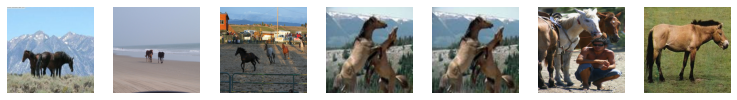

Translated (Horse -> Zebra) Images


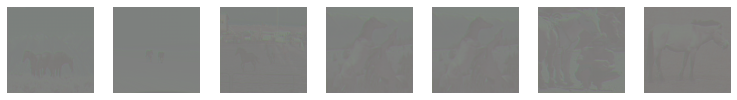

Translated reverse ( Fake Zebras -> Fake Horses)


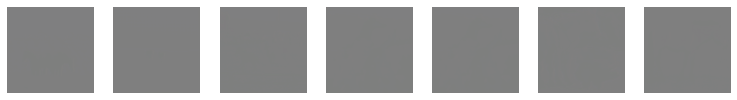

----------------------------------------------------------------------------------------------------
Input Zebra Images


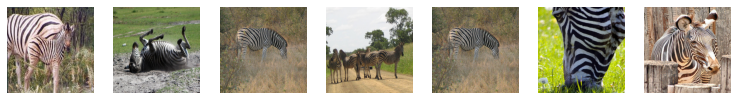

Translated (Zebra -> Horse) Images


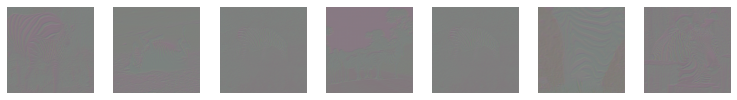

Translated reverse (Fake Horse -> Fake Zebra)


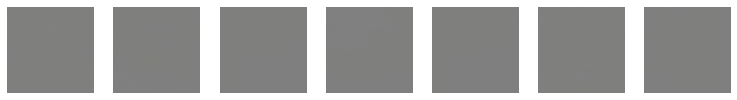

Epoch:0, Step:0, DA-Loss:2.597, DA-Acc:46.875, DB-Loss:3.503, DB-Acc:48.438, G-Loss:17.161
Epoch:0, Step:50, DA-Loss:0.390, DA-Acc:58.594, DB-Loss:0.381, DB-Acc:52.344, G-Loss:12.272


In [ ]:
epochs = 500
batch_size = 1
steps = 1000

for i in range(0, epochs):
    if i%5 == 0:
        show_generator_results_horses_to_zebras(generator_network_AB, generator_network_BA)
        print ("-"*100)
        show_generator_results_zebras_to_horses(generator_network_AB, generator_network_BA)
    for j in range(steps):  
        # A == Horses
        # B == Zebras
        domain_A_images = get_horse_samples(batch_size)
        domain_B_images = get_zebra_samples(batch_size)

        fake_patch = np.zeros((batch_size, 8, 8, 1))
        real_patch = np.ones((batch_size, 8, 8, 1))
        
        fake_B_images = generator_network_AB(domain_A_images)
        fake_A_images = generator_network_BA(domain_B_images)
        
        # Updating Discriminator A weights
        discriminator_network_A.trainable=True
        discriminator_network_B.trainable=False
        loss_d_real_A = discriminator_network_A.train_on_batch(domain_A_images, real_patch)
        loss_d_fake_A = discriminator_network_A.train_on_batch(fake_A_images, fake_patch)
        
        loss_d_A = np.add(loss_d_real_A, loss_d_fake_A)/2.0
        
        # Updating Discriminator B weights
        discriminator_network_B.trainable=True
        discriminator_network_A.trainable=False
        loss_d_real_B = discriminator_network_B.train_on_batch(domain_B_images, real_patch)
        loss_d_fake_B = discriminator_network_B.train_on_batch(fake_B_images, fake_patch)
        
        loss_d_B = np.add(loss_d_real_B, loss_d_fake_B)/2.0
        
        # Make the Discriminator belive that these are real samples and calculate loss to train the generator
        
        discriminator_network_A.trainable=False
        discriminator_network_B.trainable=False
        
        # Updating Generator weights
        loss_g = cycle_gan.train_on_batch([domain_A_images, domain_B_images],\
                    [real_patch, real_patch, domain_A_images, domain_B_images, domain_A_images, domain_B_images])
        
        if j%50 == 0:
            print ("Epoch:%.0f, Step:%.0f, DA-Loss:%.3f, DA-Acc:%.3f, DB-Loss:%.3f, DB-Acc:%.3f, G-Loss:%.3f"\
                   %(i,j,loss_d_A[0],loss_d_A[1]*100,loss_d_B[0],loss_d_B[1]*100,loss_g[0]))
            